## As our data depends on time, we are going to analyze it as a Time Series.

### ONI means that we only take into account the observations that are located in the ONI region (5N-5S, 170W-120W).

### Import libraries

In [13]:
import pandas as pd
import itertools
import statsmodels.api as sm
from pylab import rcParams

#To plot
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
cf.go_offline()

### Import and check the data

In [14]:
data = pd.read_csv('../Data/Oni_region_label.csv')
data['date'] = pd.to_datetime(data['date'])

#### We take only the period that we know from NOAA that neither Niño or Niña was on.

In [15]:
data = data[(data['date'] > '83-07-01') & (data['date'] < '97-07-01')]

In [16]:
data.tail()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,buoy_label
50256,138574,1997,6,26,1997-06-26,-5.01,-169.98,-5.6,0.3,76.5,29.11,29.21,12
50257,138575,1997,6,27,1997-06-27,-5.01,-169.99,-5.5,2.5,78.5,28.95,29.18,12
50258,138576,1997,6,28,1997-06-28,-5.01,-169.98,-5.6,-0.8,79.3,29.07,29.20,12
50259,138577,1997,6,29,1997-06-29,-5.01,-169.98,-6.5,2.1,83.7,28.37,29.18,12
50260,138578,1997,6,30,1997-06-30,-5.01,-169.98,-6.1,1.4,77.7,28.99,29.17,12


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44509 entries, 0 to 50260
Data columns (total 13 columns):
obs           44509 non-null int64
year          44509 non-null int64
month         44509 non-null int64
day           44509 non-null int64
date          44509 non-null datetime64[ns]
latitude      44509 non-null float64
longitude     44509 non-null float64
zon.winds     41474 non-null float64
mer.winds     41474 non-null float64
humidity      27830 non-null float64
air temp.     41149 non-null float64
s.s.temp.     40168 non-null float64
buoy_label    44509 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 4.8 MB


In [18]:
data.isnull().sum()

obs               0
year              0
month             0
day               0
date              0
latitude          0
longitude         0
zon.winds      3035
mer.winds      3035
humidity      16679
air temp.      3360
s.s.temp.      4341
buoy_label        0
dtype: int64

### Plot the data to see a first glimpse

In [19]:
g = data.groupby(by='date').mean()

In [20]:
g.shape

(5002, 12)

In [21]:
g.isnull().sum()

obs              0
year             0
month            0
day              0
latitude         0
longitude        0
zon.winds        0
mer.winds        0
humidity      2327
air temp.        1
s.s.temp.      212
buoy_label       0
dtype: int64

In [22]:
g['zon.winds'].rolling(window= 30).mean().iplot(kind='line', xTitle='Date',
           yTitle='Sea Surface Temperature (ºC))', title='Sea Surface Temperature between 1984 and  1998')

### Clean and take the data for the analysis

#### We group our data by months and check nan values.

In [23]:
y = data.groupby(by='date').mean().resample('MS').mean()['s.s.temp.']
y.isnull().sum()

5

In [24]:
y_rev = y

#### Finally, we plot the cleaned and ready-to-analyze data

In [25]:
y_rev.iplot(kind='line', xTitle='Time',
           yTitle='Sea Temperature (ºC)', title='Sea surface temperature between 1984 and  1998')

## Decomposition Analysis

#### Decompose the time-series into three distinct components: trend, seasonality and noise

In [26]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_rev, model='additive')
fig = decomposition.plot()
plt.show()

ValueError: This function does not handle missing values

## SARIMAX method

Autoregressive Integrated Moving Average, or ARIMA is a well established method for Time Series Analysis. However, it does not support seasonal data. As our data has seasonal components, we will use seasonal ARIMA or SARIMA instead. 

Moreover, ARIMA and SARIMA are only valid to stationary data. As the meteorological data we have tends to repeat over years (we will discard any climate change effect), we can considered it stationary. 

 Therefore, in order to analyze and forecast the meridional winds vs Time, we use the SARIMAX method.
The additional X means that the method is able to manage exogenous variables (variables that are not affected by others variables in the method). However, in this analysis we are not going to use them.

First, we need to find the most optimal SARIMAX parameters that fits with our data. To do so, we generate a combination of parameters that will be evaluated with our data. 

In [88]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets. As our data is structured in months, we set a 12 as the periodicity. 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [89]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [90]:
# Two for loops in order to try pdq and seasonal pdq parameters.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_rev,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:247.71204174707313
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:18.206174561549417
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:20.96135341374728
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4.34795669285752
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:240.52020305953192
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:12.556491263941588


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:15.474572310071698
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:7.200366342849009
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:27.281347013189755
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:7.441049913734561
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:5.569710930400403
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:5.951938349569124
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:20.961585479226105
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:9.775109435532375
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:7.506577775265572
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:7.279623471185961
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:30.40163136316665
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:7.8156552345337404
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:7.12084681409385
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-7.707687353222294
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:25.60315651032154
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:9.594024808753252
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:9.09537706446328
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(0, 0,

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-9.644495308574237
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:22.506217918805838
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:11.670560433102375
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:4.823692236814649
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:nan


The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

Thus, the parameters that are related to our most optimal fit are:

ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:4.378155989439193

#### Fitting the SARIMAX model with the previously found values. 

In [94]:
sarimax_model = sm.tsa.statespace.SARIMAX(y_rev,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = sarimax_model.fit()

# We plot the result summary
print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                          s.s.temp.   No. Observations:                   27
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                   0.811
Date:                            Tue, 23 Apr 2019   AIC                              4.378
Time:                                    18:00:45   BIC                              6.073
Sample:                                06-01-1992   HQIC                             4.030
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0972      0.271      0.358      0.720      -0.434       0.629
ar.S.L12       0.5628      0.171   

#### In order to visualize check the fitness of our model, we plot the diagnostics graphs.

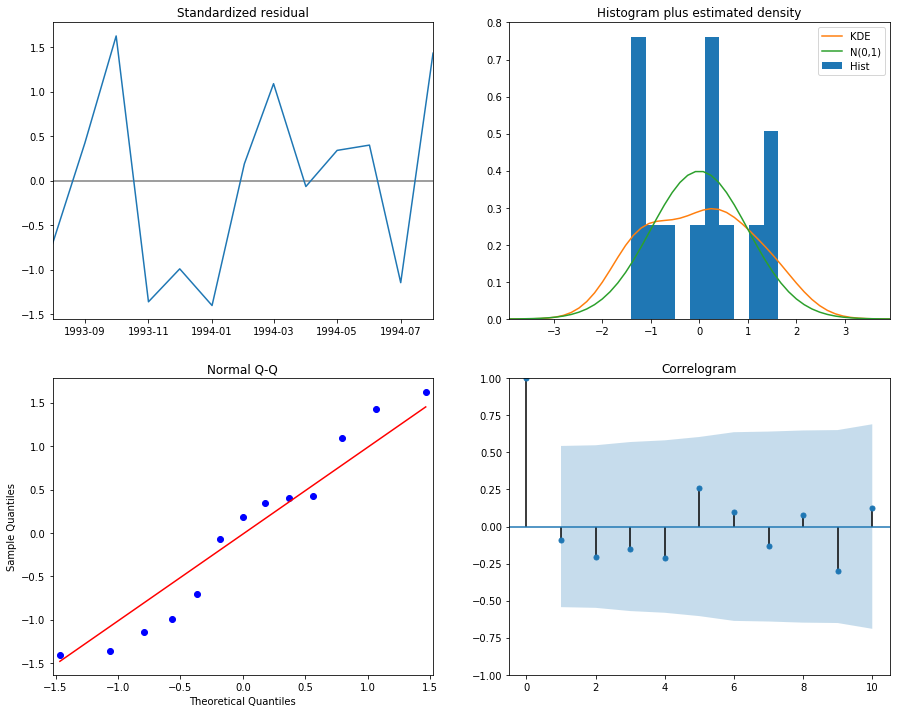

In [96]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the top right plot, we see that the red KDE line follows the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1), except for the first section of the regression. Again, this is an indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### Model prediction. 
#### We predict the meridional winds of the last years of data. 

In [97]:
pred = results.get_prediction(start=pd.to_datetime('1992-07-01'), dynamic=False)
pred_ci = pred.conf_int()

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

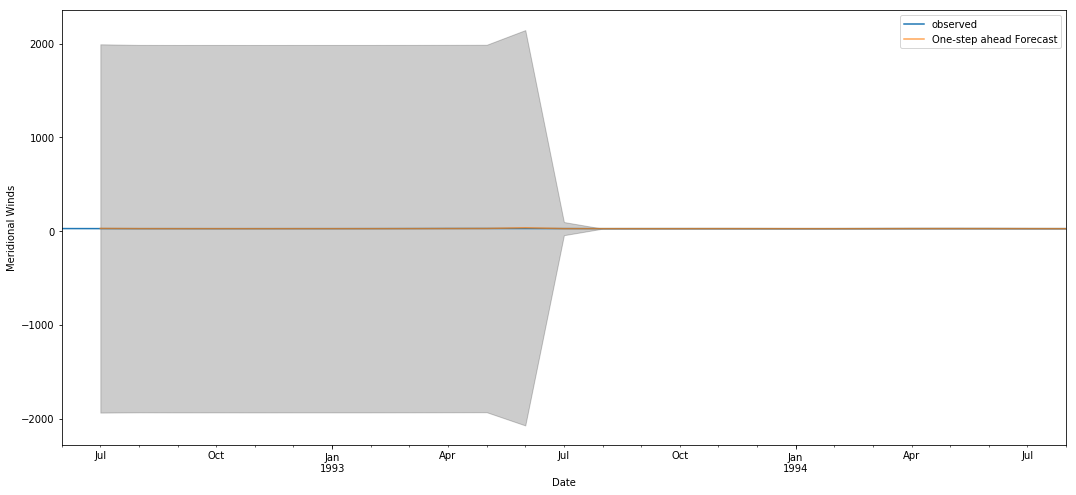

In [98]:
ax = y_rev['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Meridional Winds')
plt.legend()


plt.show()


#### Model accuracy. 
We will use the MSE (Mean Squared Error) which summarize the average error of our forecasts. 

In [101]:
y_forecasted = pred.predicted_mean
y_truth = y_rev['1992-07-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2.8


However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

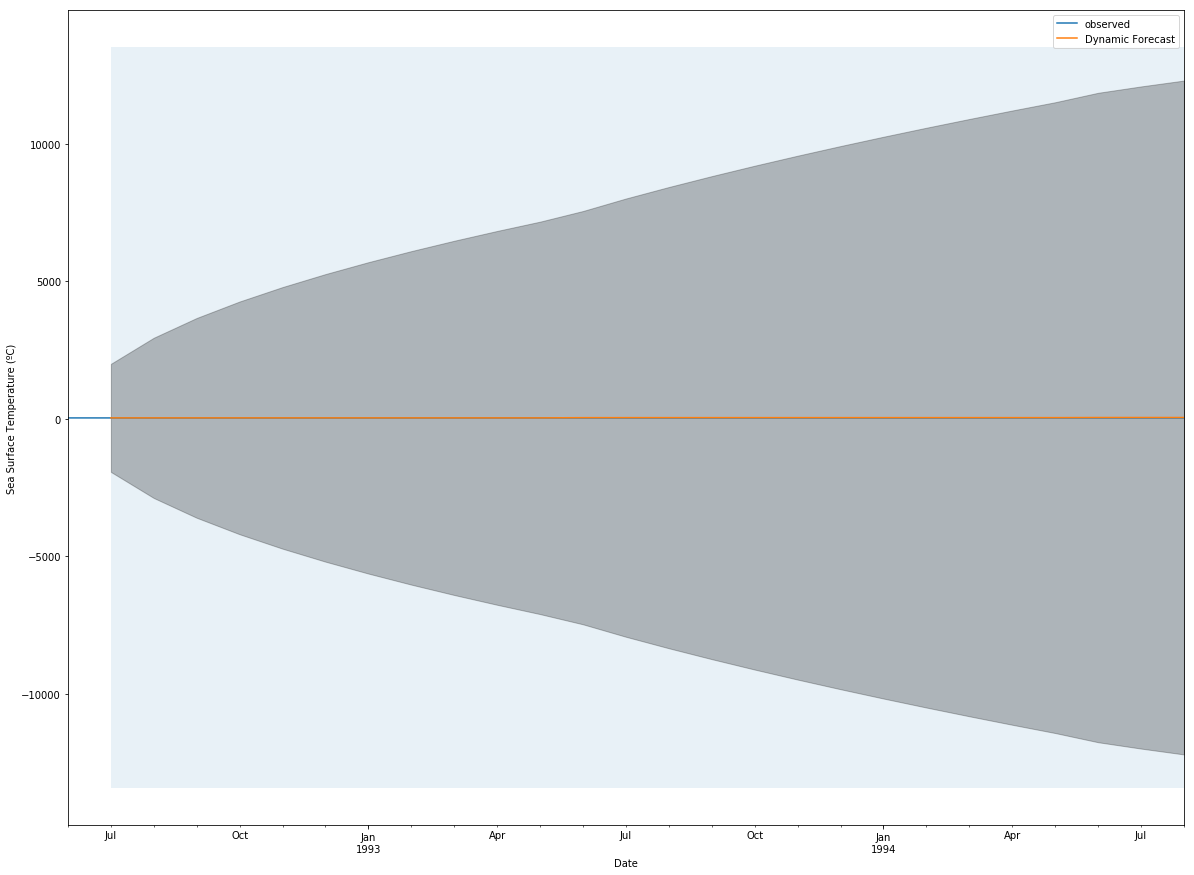

In [103]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1992-07-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('1992-07-01'),
                 y_rev.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Sea Surface Temperature (ºC)')

plt.legend()
plt.show()

In [105]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y_rev['1992-07-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 81.6


The MSE is higher than before. This is expected as we are dynamic forecast relies less on historical data. 

### Forecasting the model

#### Finally, we forecast our model predicting 100 months ahead. 

In [107]:
# Get forecast 100 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



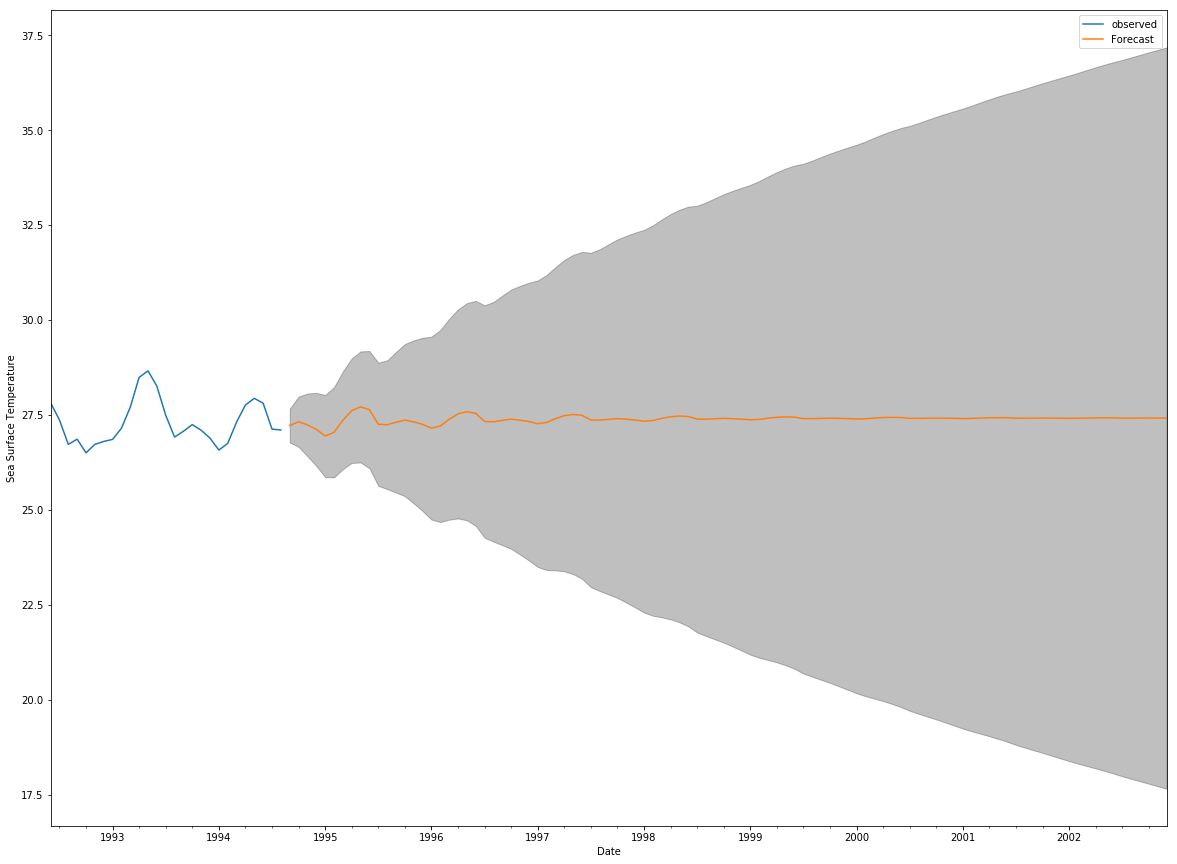

In [108]:
ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sea Surface Temperature')

plt.legend()
plt.show()


# Try to understand this.

### Compare el niño vs normal periods

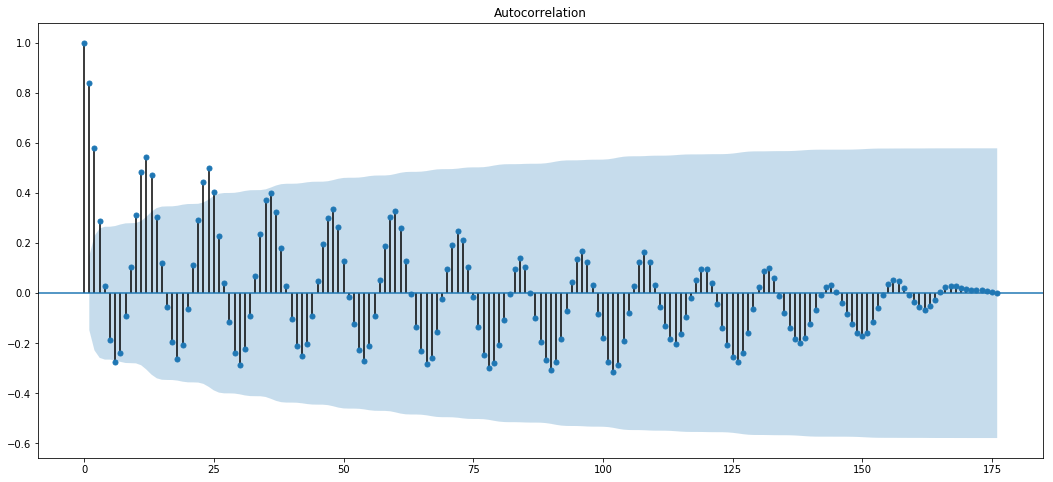

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_rev)
plt.show()

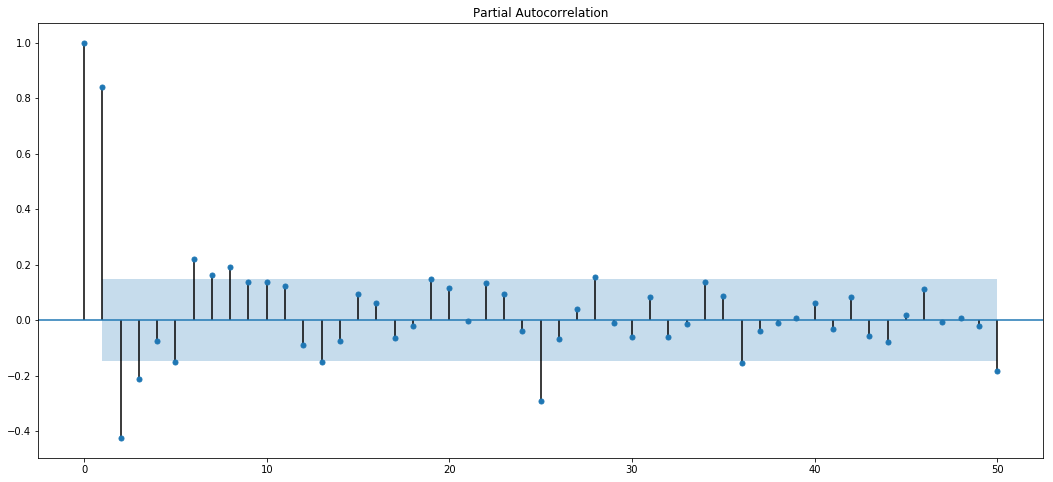

In [84]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_rev, lags=50)
plt.show()